# Analysis of Oscilloscope Data Captured on 2018-06-05

This notebook analyses the output from a signal generator against the amplified signal.

The average peak-to-peak voltage is calculated along with the standard error of the mean (SEM). 

The average gain is then calculated using the peak-to-peak voltage for the original signal and the amplified signal. Again this includes the SEM.

The effect of changing the amplitude of the income signal is investigated as well.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
from scipy.signal import find_peaks

df_origin = pd.read_csv('2. Testing the Amplifier/ALL0003/F0003CH2.csv',header=None)    # Original signal
df_amp = pd.read_csv('2. Testing the Amplifier/ALL0003/F0003CH3.csv',header=None)       # Amplified signal

In [2]:
df_origin.head(20)

,0,1,2,3,4,5
0,Record Length,2.500000e+03,NaN,-0.000003,0.00304,NaN
1,Sample Interval,2.000000e-09,NaN,-0.000002,0.00304,NaN
2,Trigger Point,1.250000000000e+03,NaN,-0.000002,0.00304,NaN
3,NaN,NaN,NaN,-0.000002,0.00312,NaN
4,NaN,NaN,NaN,-0.000002,0.00304,NaN
5,NaN,NaN,NaN,-0.000002,0.00272,NaN
6,Source,CH2,NaN,-0.000002,0.00296,NaN
7,Vertical Units,V,NaN,-0.000002,0.00296,NaN
8,Vertical Scale,2.000000e-03,NaN,-0.000002,0.00264,NaN
9,Vertical Offset,0.000000e+00,NaN,-0.000002,0.00304,NaN


The .csv file produced by the Tektronix 2024-B oscilloscope has the first two columns with information on the vertical and horizontal (or y and x) scales, offests and units used as well as model details. We are interested in the 4th and 5th columns (index 3 and 4) for the x and y data respectively.

In [3]:
df_origin.columns = ['titles','values','no_info1','time','V','no_info2']
df_amp.columns = df_origin.columns

df_org_sig = df_origin[['time','V']]
df_amp_sig = df_amp[['time','V']]

In [4]:
df_org_sig.head(5)

,time,V
0,-0.000003,0.00304
1,-0.000002,0.00304
2,-0.000002,0.00304
3,-0.000002,0.00312
4,-0.000002,0.00304


In [5]:
df_amp_sig.head(5)

,time,V
0,-0.000003,0.64
1,-0.000002,0.64
2,-0.000002,0.64
3,-0.000002,0.52
4,-0.000002,0.52


Plot the data to get an idea of how it looks like

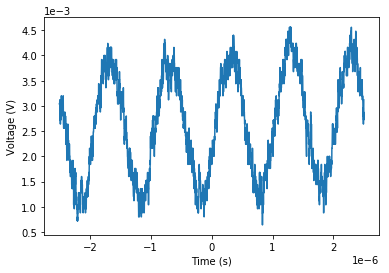

In [6]:
plt.plot(df_org_sig['time'],df_org_sig['V'])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

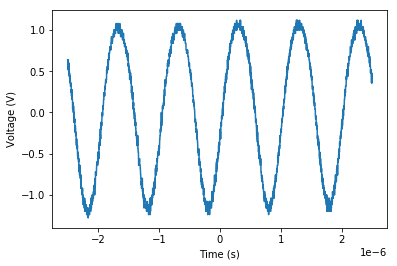

In [7]:
plt.plot(df_amp_sig['time'],df_amp_sig['V'])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

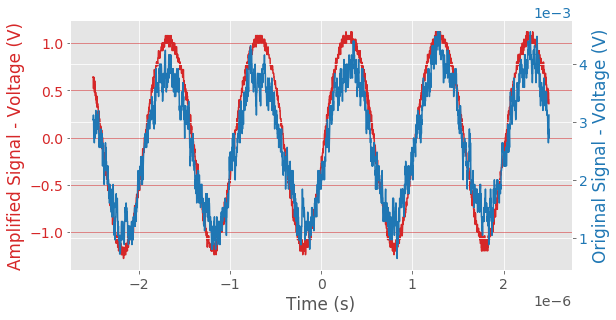

In [8]:
# Create function to plot the amplified signal against the original signal
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}

def plot_amp_vs_org(x_data,y_amp_data,y_org_data,figheight,figwidth):
    plt.style.use('ggplot')
    plt.rc('font', **font)
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplified Signal - Voltage (V)', color=color)
    ax1.plot(x_data, y_amp_data, color=color)
    
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(color=color, linestyle='-', linewidth=0.5, axis='y')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Original Signal - Voltage (V)', color=color)  # handled the x-label with ax1
    ax2.plot(x_data, y_org_data, color=color)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.set_figheight(figheight)
    fig.set_figwidth(figwidth)
    return fig

Fig1 = plot_amp_vs_org(df_amp_sig['time'],df_amp_sig['V'],df_org_sig['V'],5,10)
plt.show(Fig1)


As can be seen from the plots above, the amplified signal is much too large to display on the same graph as the amplified signal without first normalizing. That is what we will do next. We will also look at the case of shifting the mean to zero for both signals:

In [9]:
# The following function will normalize the array data to be within the range [0 1]:
def data_norm(data):
    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.MinMaxScaler()
    # Scale the data
    return min_max_scaler.fit_transform(data)

# Function to find the waveform with a mean of zero:
def shift_mean0(waveform):
    # Shift the data so that mean is zero:
    return waveform - waveform.mean()

# Run the normalizer on the dataframe
df_org_norm = pd.DataFrame(data_norm(df_org_sig[['V']]))
df_amp_norm = pd.DataFrame(data_norm(df_amp_sig[['V']]))

Investigate whether the results look reasonable:

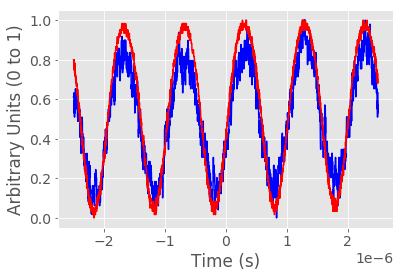

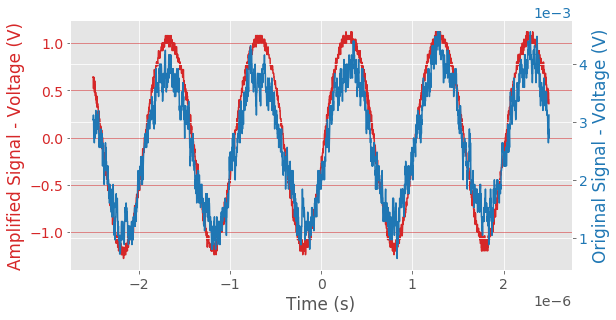

In [10]:
plt.plot(df_org_sig['time'],df_org_norm, 'b', df_amp_sig['time'],df_amp_norm, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Arbitrary Units (0 to 1)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

Fig2 = plot_amp_vs_org(df_amp_sig['time'],(df_amp_sig['V']),(df_org_sig['V']),5,10)
#plt.savefig('DSO_Output_Trial1.eps')
plt.show(Fig2)

Now that we have normalized the data for both the original and amplified signal, we can clearly see that the two are in phase. This means that the amplification process is produced a relatively accurate reproduction of the original signal. This will allow us now to quantify the peak-to-peak voltage of the input and output signals so that we can determine the gain. The p2p_V_avg function (defined later down) does exactly that by finding the peaks in the signal and using a 'scipy' module called 'signal', specifically the method 'find_peaks'. After finding the peaks, average values of the voltage are taken around these peaks are determind and then the peak-to-peak voltage calculated by finding the distance between successive peaks. 

We can quickly see how this works by finding the peaks for the amplified and original signal. Firstly normalizing to a mean of 0 for each and then ensuring all values are positive:

In [11]:
# Shift the data so that mean is zero:
df_org_mean0 =  df_org_sig['V'] - df_org_sig['V'].mean()
df_amp_mean0 =  df_amp_sig['V'] - df_amp_sig['V'].mean()

# For each of the values in the voltage data above, find the distance to the new mean
df_org_dist = abs(df_org_mean0 - df_org_mean0.mean())
df_amp_dist = abs(df_amp_mean0 - df_amp_mean0.mean())

# Find the peaks in the distance values. These will correspond to the minima and maxima of the signal
org_peaks, _ = find_peaks(df_org_dist, prominence=df_org_dist.mean())
amp_peaks, _ = find_peaks(df_amp_dist, prominence=df_amp_dist.mean())

And then plot the result:

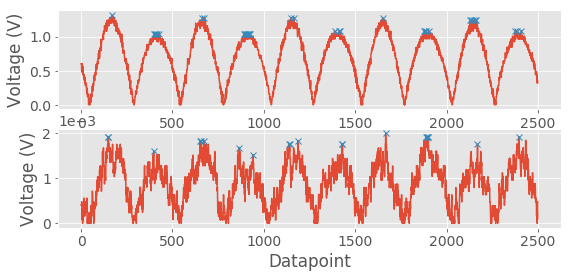

In [12]:
plt.figure(figsize=(9,4))
plt.subplot(211)
plt.plot(df_amp_dist)
plt.plot(amp_peaks, df_amp_dist[amp_peaks], "x")
plt.xlabel('Datapoint')
plt.ylabel('Voltage (V)')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.subplot(212)
plt.plot(df_org_dist)
plt.plot(org_peaks, df_org_dist[org_peaks], "x")
plt.xlabel('Datapoint')
plt.ylabel('Voltage (V)')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

As can be seen above, the method is quite good at locating the peaks in both signals. However, this is true moreso for the amplified signal than the original and therefore we will use only the peaks identified in the amplified signal as the reference points for the location of the peaks. All that needs to be done is to use a few values around these peaks to get a good estimate of peak voltage.

Below we will now define the peak-to-peak voltage function. It will gives us the peak-to-peak voltage between each peak and the standard errors of the mean (SEMs) for each of the calculations.

In [13]:
# Function to calculate the index of the median position of the peaks 
def med_peak(waveform, percent):
    # Shift the data so that mean is zero:
    wf_mean0 =  waveform - waveform.mean()
    # For each of the values in the voltage data above, find the distance to the new mean
    wf_dist = abs(wf_mean0 - wf_mean0.mean())
    # wf_dist is now all positive therefore, one cannot differentiate between peak and trough
    # The aim now is to find the distance between successive peaks - this is the p2p voltage
    peaks, _ = find_peaks(wf_dist, width = 6, prominence=wf_dist.mean())
    # We now have the indexes of the peaks of wf_dist. Some of these indexes will point to the same
    # original peak or trough. Therefore we need to go through and find the median index of any
    # series of indexes that point to the same peak/trough. We will use the fact that the original
    # wf_mean0 data goes from positive to negative and back when transitioning from a peak to a 
    # trough:
    end_i = []
    for i in range(len(peaks)-1):
        if wf_mean0[peaks[i+1]]/wf_mean0[peaks[i]] < 0:
            end_i.append(i)
    median_peaks = []
    sem_peaks = []
    # Now we find the median peak indexes and standard deviation:
    for i in range(len(end_i)):
        if i == 0:
            median_peaks.append(int(np.median(peaks[0:end_i[i]+1])))
            sem_peaks.append(np.nan_to_num(stats.sem(peaks[0:end_i[i]+1])))
        else:
            median_peaks.append(int(np.median(peaks[end_i[i-1]+1:end_i[i]+1])))
            sem_peaks.append(np.nan_to_num(stats.sem(peaks[end_i[i-1]+1:end_i[i]+1])))
    # Compare SEM to the measurement error on the DSO of 2%, if less 
    #peak_sem = []
    #for sem in sem_peaks:
    #    if sem < len(df_org_sig['V'])*percent/2:
    #        peak_sem.append(len(df_org_sig['V'])*percent/2)
    #    else:
    #        peak_sem.append(sem)
    return median_peaks, sem_peaks

# Function to take in a 1D waveform and find the average peak-to-peak voltage
# Output is a list of the average value and the SEM as a tuple
def p2p_V_avg(waveform, waveform_4_peaks, percent):
    median_peaks, sem_peaks = med_peak(waveform_4_peaks,percent)
    # We will check if the SEM of the peaks are greater or less than the 2% error expected from the DSO.
    # If the SEM is larger, this will be the error that is used, otherwise it will be set at 2%
    # We will assume that the median index is within (percentx100)% of the true peak position and therefore, we
    # will now average the values of the voltage within (percentx100)% of the median index found. we will also
    # calculate the SEM for the values that have been averaged:
    band_idx = int(percent*len(waveform)/2)
    peak_avgs = []
    for peak_idx in median_peaks:
        low_b = peak_idx-band_idx
        up_b = peak_idx+band_idx
        p_sem_tup = (waveform[low_b:up_b].mean(),stats.sem(waveform[low_b:up_b]))
        peak_avgs.append(p_sem_tup)
        low_b = None
        up_b = None
        p_sem_tup = None
    # We now find the peak-to-peak voltage, taking the difference between successive peaks:
    p2p_V_list = []
    for avg_idx in range(len(peak_avgs)-1):
        V_p2p = abs(peak_avgs[avg_idx][0]-peak_avgs[avg_idx+1][0])
        sem_V = np.sqrt(peak_avgs[avg_idx][1]**2 + peak_avgs[avg_idx+1][1]**2) 
        p2p_V_list.append((V_p2p,sem_V))
    return p2p_V_list, peak_avgs


In [14]:
print(len(df_org_sig['V'])*0.02)
print(org_peaks)
print()
med_peak(df_org_sig['V'],0.02)

50.0
[ 147  149  397  651  655  672  864  940 1138 1141 1188 1427 1430 1667
 1889 1894 1897 1900 2169 2397]



C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


([148, 397, 655, 902, 1141, 1428, 1667, 1895, 2169],
 [1.0,
  0.0,
  6.437735971942656,
  38.0,
  16.189845926107857,
  1.4999999999999998,
  0.0,
  2.345207879911715,
  0.0])

Firstly, we will calculate the frequency of the sine wave by considering the distance between peaks in terms of the index (or datapoint) and the time between each datapoint - this gives the period which can be used to calculate the frequency

In [15]:
# Calculate the frequency of the wave
def freq_mean(x_time,y_waveform,percent):
    median_peaks, sem_peaks = med_peak(y_waveform,percent)

    dist_betw_peaks = [median_peaks[i+2] - median_peaks[i] for i in range(len(median_peaks)-2)]
    sem_dist = [np.sqrt(sem_peaks[i+2]**2 + sem_peaks[i]**2) for i in range(len(sem_peaks)-2)]
    time_betw_xval = x_time[1] - x_time[0]

    # Period
    periods = [dist*time_betw_xval for dist in dist_betw_peaks]
    sem_p = [sem*time_betw_xval for sem in sem_dist]
    percent_err = [sem/period for sem,period in zip(sem_p,periods)]
    freq = [x**-1 for x in periods]
    mean_freq = np.array(freq).mean()
    freq_err = mean_freq*(np.sqrt(np.array(sum([x**2 for x in percent_err]))))
    
    return (mean_freq, freq_err)

mean_freq, sem_freq = freq_mean(df_amp_sig['time'],df_amp_sig['V'],0.01)
print(mean_freq)
print(sem_freq)
print('Percentage of Error:'+str(sem_freq/mean_freq))

mean_freq_org, sem_freq_org = freq_mean(df_org_sig['time'],df_org_sig['V'],0.01)
print(mean_freq_org)
print(sem_freq_org)
print('Percentage of Error:'+str(sem_freq_org/mean_freq_org))

1014946.6198859523
46473.497943200986
Percentage of Error:0.04578910558707327
996131.331482429
114977.13506683482
Percentage of Error:0.11542367098897233


C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
x_ra = np.array(([4.,2.,8.,5.,3.,9.,4.,1.,3.,7.]))
print('List:'+str(x_ra))
print('List Mean:'+str(x_ra.mean()))
print('List Inverse:'+str((x_ra)**-1))
print('List Mean - Inverse:'+str( (x_ra.mean())**-1 ) )
print('List Inverse - Mean:'+str(((x_ra)**-1).mean()))


List:[4. 2. 8. 5. 3. 9. 4. 1. 3. 7.]
List Mean:4.6
List Inverse:[0.25       0.5        0.125      0.2        0.33333333 0.11111111
 0.25       1.         0.33333333 0.14285714]
List Mean - Inverse:0.2173913043478261
List Inverse - Mean:0.32456349206349205


In [17]:
sum([4.,2.,8.,5.,3.,9.,4.,1.,3.,7.])

46.0

We can now calculate the peak-to-peak voltages for the amplified and original signal and also calculate the gain:

In [18]:
# Amplified signal p2p voltages:
p2p_V_amp, peak_avg_amp = p2p_V_avg(df_amp_sig['V'],df_amp_sig['V'],0.02)
print('Percentage Error = '+str(p2p_V_amp[0][1]/p2p_V_amp[0][0]))
print('Mean = '+str(np.array([x[0] for x in p2p_V_amp]).mean()))
#p2p_V_amp

Percentage Error = 0.003973008350786759
Mean = 2.1754999999999987


C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
# Original signal p2p voltages:
p2p_V_org, peak_avg_org = p2p_V_avg(df_org_sig['V'],df_org_sig['V'],0.02)
print('Percentage Error = '+str(p2p_V_org[0][1]/p2p_V_org[0][0]))
print('Mean = '+str(np.array([x[0] for x in p2p_V_org]).mean()))
#p2p_V_org

Percentage Error = 0.0182278093873796
Mean = 0.0026476


C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
# Calcualte gain
#gain_p2p_V = np.array([x[0] for x in p2p_V_amp])/np.array([x[0] for x in p2p_V_org])
# Calculate uncertainties of gain
#gain_p2p_sem = gain_p2p_V*np.sqrt((np.array([x[1] for x in p2p_V_amp])/np.array([x[0] for x in p2p_V_amp]))**2 + (np.array([x[1] for x in p2p_V_org])/np.array([x[0] for x in p2p_V_org]))**2)
#print(gain_p2p_V.mean())
#print(gain_p2p_sem.mean())
#print(gain_p2p_sem.mean()/gain_p2p_V.mean())
#np.sqrt(sum(np.array([(x/len(gain_p2p_sem))**2 for x in gain_p2p_sem])))

# Calcualte average gain
mean_V_amp = np.array([x[0] for x in p2p_V_amp]).mean()
mean_V_org = np.array([x[0] for x in p2p_V_org]).mean()
gain_mean = mean_V_amp/mean_V_org
# Uncertainties in average gain calculation
mean_err_V_amp = np.sqrt(np.sum(np.array([x[1]**2 for x in p2p_V_amp])))/(len(p2p_V_amp))
mean_err_V_org = np.sqrt(np.sum(np.array([x[1]**2 for x in p2p_V_org])))/(len(p2p_V_org))
gain_p2p_sem = gain_mean*np.sqrt( (mean_err_V_amp/mean_V_amp) + ((mean_err_V_org/mean_V_org)) ) 

In [21]:
# Define the column names for the table
column_name = ['Amplified Frequency (Hz)','SEM_Freq','Original pk-pk Voltage (V)','SEM_Original','Amplified pk-pk Voltage (V)','SEM_Amplified','Gain (Amplified/Original)','SEM_Gain']
# Create table
info_g = np.array([mean_freq,sem_freq,mean_V_org, mean_err_V_org, mean_V_amp, mean_err_V_amp, gain_mean, gain_p2p_sem])
df_info = pd.DataFrame(info_g, index = column_name, columns = ['Gain Achieved by Amplifier'])
pd.set_option('display.float_format', lambda x: '{:.2e}'.format(x) if x<0.01  else '{:.3g}'.format(x))
df_info

,Gain Achieved by Amplifier
Amplified Frequency (Hz),1.01e+06
SEM_Freq,4.65e+04
Original pk-pk Voltage (V),2.65e-03
SEM_Original,1.59e-05
Amplified pk-pk Voltage (V),2.18
SEM_Amplified,3.09e-03
Gain (Amplified/Original),822
SEM_Gain,70.7


## Lowering amplitude on the signal generator

We can now apply the methods above to the case of the other samples where the amplitude from the signal generator is decreased

In [22]:
import os

org_files = []
amp_files = []
for root, dirs, files in os.walk("2. Testing the Amplifier"):
    for file in files:
        if file.endswith("CH2.CSV"):
             org_files.append(os.path.join(root, file))
        if file.endswith("CH3.CSV"):
             amp_files.append(os.path.join(root, file))                

In [23]:
new_org = org_files[3:-1]
new_amp = amp_files[2:-1]

In [24]:
new_org

['2. Testing the Amplifier\\ALL0003\\F0003CH2.CSV',
 '2. Testing the Amplifier\\ALL0004\\F0004CH2.CSV',
 '2. Testing the Amplifier\\ALL0005\\F0005CH2.CSV',
 '2. Testing the Amplifier\\ALL0006\\F0006CH2.CSV',
 '2. Testing the Amplifier\\ALL0007\\F0007CH2.CSV']

In [25]:
# Function for reading and extracting relevant data
def data_output_csv(filename):
    df_raw = pd.read_csv(filename,header=None)
    df_raw.columns = ['titles','values','no_info1','time','V','no_info2']
    return df_raw[['time','V']]

# Now we can run through all the .csv files and create data frames
df_V_org_list = []
for filename in new_org:
    df_V_org_list.append(data_output_csv(filename))

df_V_amp_list = []
for filename in new_amp:
    df_V_amp_list.append(data_output_csv(filename))


In [26]:
df_V_amp_list[0]['time'].head(5)

0   -2.50e-06
1   -2.50e-06
2   -2.50e-06
3   -2.49e-06
4   -2.49e-06
Name: time, dtype: float64

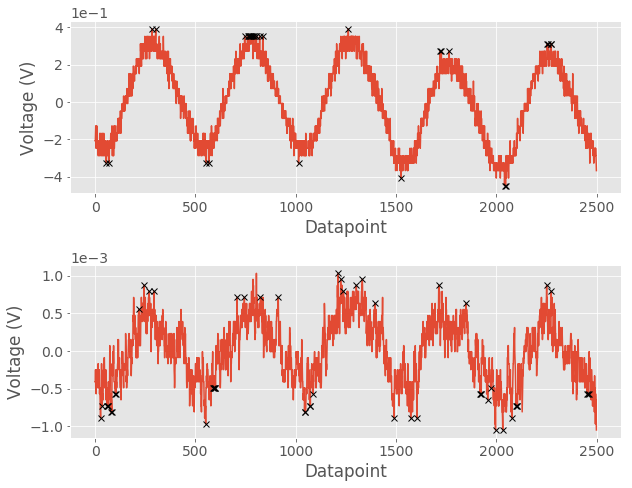

In [27]:
def peak_compare(org_sig,amp_sig):
    org_mean = org_sig['V'] - org_sig['V'].mean()
    amp_mean = amp_sig['V'] - amp_sig['V'].mean()
    
    pos_org_sig = abs(org_mean - org_mean.mean())
    pos_amp_sig = abs(amp_mean - amp_mean.mean())
    
    org_peaks, _ = find_peaks(pos_org_sig, width = 6, prominence=pos_org_sig.mean())
    amp_peaks, _ = find_peaks(pos_amp_sig, width = 6, prominence=pos_amp_sig.mean())
    
    fig = plt.figure(figsize=(9,7))
    #fig, ax = plt.subplots(4,1)
    plt.subplot(211)
    plt.plot(amp_mean)
    plt.plot(amp_peaks, amp_mean[amp_peaks], "x",color='k')
    plt.xlabel('Datapoint')
    plt.ylabel('Voltage (V)')
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.subplot(212)
    plt.plot(org_mean)
    plt.plot(org_peaks, org_mean[org_peaks], "x",color='k')
    plt.xlabel('Datapoint')
    plt.ylabel('Voltage (V)')
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.tight_layout()
    return fig


Fig4 = peak_compare(df_V_org_list[4],df_V_amp_list[4])
#plt.savefig('Peak_Compare.eps')
plt.show(Fig4)

# Shift the data so that mean is zero:
#df_org_mean3 =  df_V_org_list[3]['V'] - df_V_org_list[3]['V'].mean()
#df_amp_mean3 =  df_V_amp_list[3]['V'] - df_V_amp_list[3]['V'].mean()

# For each of the values in the voltage data above, find the distance to the new mean
#df_org_dist3 = abs(df_org_mean3 - df_org_mean3.mean())
#df_amp_dist3 = abs(df_amp_mean3 - df_amp_mean3.mean())

# Find the peaks in the distance values. These will correspond to the minima and maxima of the signal
#org_peaks4, _ = find_peaks(df_org_dist4, prominence=df_org_dist4.mean())
#amp_peaks4, _ = find_peaks(df_amp_dist4, prominence=df_amp_dist4.mean())



In [28]:
df_V_amp_list[0]['V'].head(15)

0    0.64
1    0.64
2    0.64
3    0.52
4    0.52
5    0.64
6    0.52
7    0.56
8    0.56
9    0.48
10    0.6
11   0.52
12   0.48
13   0.48
14   0.44
Name: V, dtype: float64

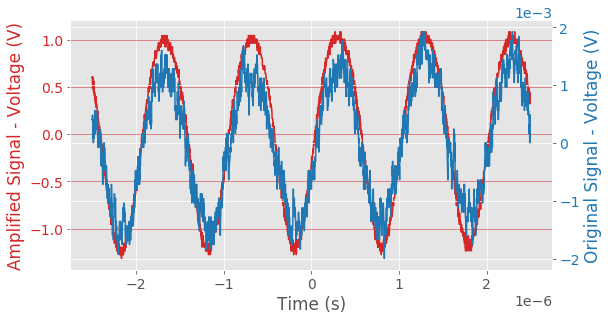

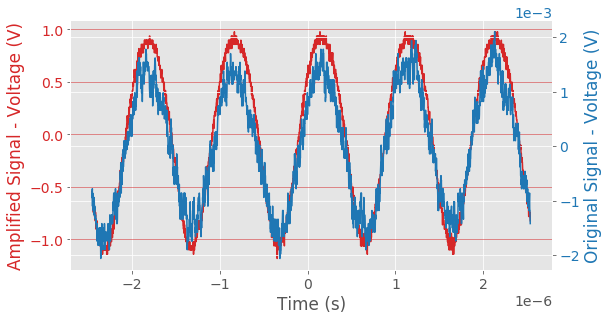

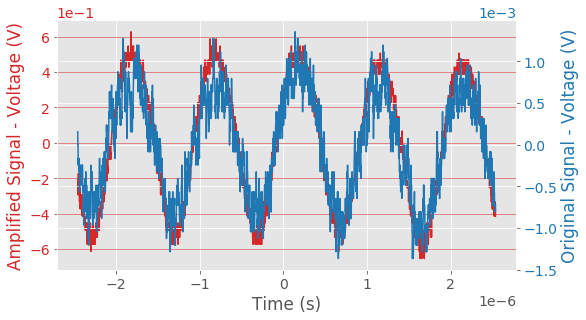

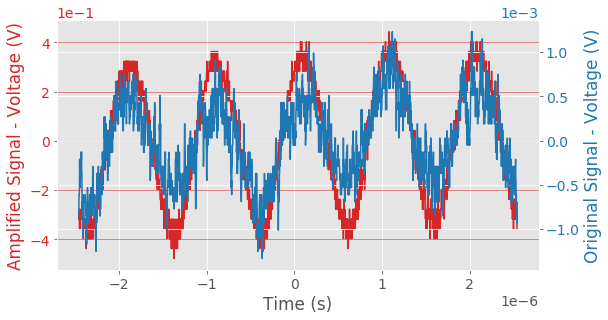

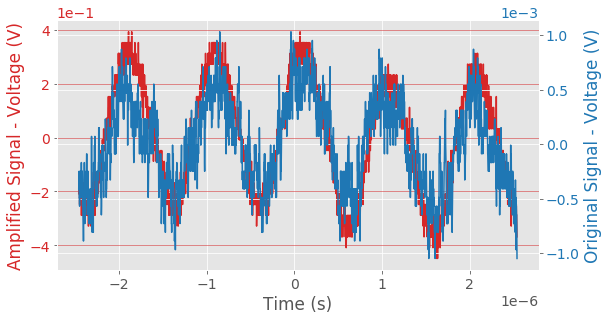

In [29]:
# Plot them on top of each other for comparison
for i in range(len(df_V_amp_list)):
    plot_amp_vs_org(df_V_amp_list[i]['time'],shift_mean0(df_V_amp_list[i]['V']),shift_mean0(df_V_org_list[i]['V']),5,10)
    #plt.savefig('Sig_Comp_Trial_'+str(i+1)+'.eps')
    

In [30]:
df_V_amp_list[0]['V'].head(10)

0   0.64
1   0.64
2   0.64
3   0.52
4   0.52
5   0.64
6   0.52
7   0.56
8   0.56
9   0.48
Name: V, dtype: float64

In [62]:
# Calculate the mean frequencies, p2p voltages (and mean) for each of the signals and the average gain:
freq_amp_list = []
freq_org_list = []
p2p_V_amp_list = []
p2p_V_org_list = []
p2p_V_amp_mean = []
p2p_V_org_mean = []
gain_p2p_V_list = []
gain_p2p_sem_list = []
gain_list = []
for i in range(len(df_V_amp_list)):
    # Calculate mean Frequencies
    freq_amp_list.append(freq_mean(df_V_amp_list[i]['time'],df_V_amp_list[i]['V'],0.01))
    freq_org_list.append(freq_mean(df_V_org_list[i]['time'],df_V_org_list[i]['V'],0.01))
    # Calculate p2p voltages and means
    p2p_V_amps, _ = p2p_V_avg(df_V_amp_list[i]['V'],df_V_amp_list[i]['V'],0.01)
    p2p_V_amp_list.append(p2p_V_amps)
    p2p_V_org, _ = p2p_V_avg(df_V_org_list[i]['V'],df_V_amp_list[i]['V'],0.01)
    p2p_V_org_list.append(p2p_V_org)
    # Calcualte average gain
    mean_V_amp = np.array([x[0] for x in p2p_V_amps]).mean()
    mean_V_org = np.array([x[0] for x in p2p_V_org]).mean()
    gain_mean = np.array([x[0] for x in p2p_V_amps]/np.array([x[0] for x in p2p_V_org])).mean()
    gain_p2p_V_list.append(gain_mean)
    # Uncertainties in average gain calculation
    mean_err_V_amp = np.sqrt(np.sum(np.array([(x[1])**2 for x in p2p_V_amps])))/(len(p2p_V_amps))
    mean_err_V_org = np.sqrt(np.sum(np.array([(x[1])**2 for x in p2p_V_org])))/(len(p2p_V_org))
    gain_p2p_sem_list.append(gain_mean*np.sqrt( (mean_err_V_amp/mean_V_amp) + ((mean_err_V_org/mean_V_org)) ) )
    p2p_V_amp_mean.append((mean_V_amp,mean_err_V_amp))
    p2p_V_org_mean.append((mean_V_org,mean_err_V_org))
    gain_list.append((gain_mean,gain_p2p_sem_list[i]))



C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [32]:
np.array([x[0] for x in gain_list]).mean()

691.9073180265119

In [33]:
p2p_V_amp_mean

[(2.21, 0.03277798247704852),
 (1.937857142857143, 0.03161704731880289),
 (0.9966666666666667, 0.03103683334611619),
 (0.6909523809523811, 0.028712299372667813),
 (0.5614583333333335, 0.031100973158423292)]

In [34]:
freq_amp_list

[(1014946.6198859523, 46473.497943200986),
 (1021655.0270543066, 5223.185209889093),
 (1009413.2855647505, 84273.05413181962),
 (1012186.2849640044, 46188.19441239609),
 (1027201.3748224907, 49571.00768590891)]

In [35]:
freq_org_list

[(996131.331482429, 114977.13506683482),
 (986734.4303175418, 30141.180668738867),
 (1005270.9196830296, 183515.93243500462),
 (1020384.1779949578, 199513.49160256493),
 (1020569.583911015, 283369.2484610344)]

In [36]:
p2p_V_amp_mean

[(2.21, 0.03277798247704852),
 (1.937857142857143, 0.03161704731880289),
 (0.9966666666666667, 0.03103683334611619),
 (0.6909523809523811, 0.028712299372667813),
 (0.5614583333333335, 0.031100973158423292)]

In [37]:
p2p_V_org_mean

[(0.0026633333333333335, 0.0001498952935679317),
 (0.002875714285714285, 0.00012137497294735442),
 (0.0014745833333333334, 0.00015114218918838316),
 (0.0011333333333333334, 0.00014220825716461442),
 (0.0009266666666666665, 0.0001353506806901429)]

In [38]:
gain_p2p_V_list

[836.2661593970201,
 676.9588248112203,
 693.7555644870602,
 631.9225718950871,
 620.6334695421714]

In [63]:
gain_p2p_sem_list

[78.84483968349959,
 61.89765066783917,
 89.66601817661788,
 97.61473923117435,
 98.48709228438477]

In [40]:
for i in range(len(gain_p2p_V_list)):
    print(gain_p2p_V_list[i]/gain_p2p_sem_list[i])

    

3.7499567160018903
4.133701080866094
2.735480364302739
2.4468055106239994
2.227977924647212


In [41]:
np.array([x[0] for x in p2p_V_org_mean])

array([0.00266333, 0.00287571, 0.00147458, 0.00113333, 0.00092667])

In [42]:
gain_p2p_V_list

[836.2661593970201,
 676.9588248112203,
 693.7555644870602,
 631.9225718950871,
 620.6334695421714]

In [64]:
#indexes = ['Trial 1','Trial 2','Trial 3','Trial 4', 'Trial 5']
# Define the column names for the table
column_name = ['Original Frequency (Hz)','SEM_Org_Freq','Amplified Frequency (Hz)','SEM_Amp_Freq','Original pk-pk Voltage (V)','SEM_Original','Amplified pk-pk Voltage (V)','SEM_Amplified','Gain (Amplified/Original)','SEM_Gain']
new_arr = pd.DataFrame(freq_org_list)
new_arr.insert(2,2,[x[0] for x in freq_amp_list])
new_arr.insert(3,3,[x[1] for x in freq_amp_list])
new_arr.insert(4,4,[x[0] for x in p2p_V_org_mean])
new_arr.insert(5,5,[x[1] for x in p2p_V_org_mean])
new_arr.insert(6,6,[x[0] for x in p2p_V_amp_mean])
new_arr.insert(7,7,[x[1] for x in p2p_V_amp_mean])
new_arr.insert(8,8,gain_p2p_V_list)
new_arr.insert(9,9,gain_p2p_sem_list)
#new_arr = np.insert(new_arr,1,[x[1] for x in p2p_V_org_mean],axis=1)
#for i in range(len(p2p_V_org_mean)):
#    new_arr.append(list(p2p_V_org_mean[i] + p2p_V_amp_mean[i]))
new_arr.columns = column_name
#new_arr.index = indexes
pd.set_option('display.float_format', lambda x: '{:.2e}'.format(x) if x<0.01 else '{:.3g}'.format(x))
new_arr


,Original Frequency (Hz),SEM_Org_Freq,Amplified Frequency (Hz),SEM_Amp_Freq,Original pk-pk Voltage (V),SEM_Original,Amplified pk-pk Voltage (V),SEM_Amplified,Gain (Amplified/Original),SEM_Gain
0,9.96e+05,1.15e+05,1.01e+06,4.65e+04,2.66e-03,1.87e-05,2.21,4.10e-03,836,78.8
1,9.87e+05,3.01e+04,1.02e+06,5.22e+03,2.88e-03,1.73e-05,1.94,4.52e-03,677,61.9
2,1.01e+06,1.84e+05,1.01e+06,8.43e+04,1.47e-03,1.89e-05,0.997,3.88e-03,694,89.7
3,1.02e+06,2e+05,1.01e+06,4.62e+04,1.13e-03,2.03e-05,0.691,4.10e-03,632,97.6
4,1.02e+06,2.83e+05,1.03e+06,4.96e+04,9.27e-04,1.69e-05,0.561,3.89e-03,621,98.5


In [77]:
np.array(gain_p2p_V_list[0:3]).mean()

735.6601828984336

In [76]:
stats.sem(gain_p2p_V_list)

38.56454316625721

In [74]:
np.sqrt(np.sum(np.array([(x)**2 for x in gain_p2p_sem_list])))/(len(gain_p2p_sem_list))

38.63478607698884

In [57]:
new_arr

,Original Frequency (Hz),SEM_Org_Freq,Amplified Frequency (Hz),SEM_Amp_Freq,Original pk-pk Voltage (V),SEM_Original,Amplified pk-pk Voltage (V),SEM_Amplified,Gain (Amplified/Original),SEM_Gain
0,9.96e+05,1.15e+05,1.01e+06,4.65e+04,2.66e-03,1.50e-04,2.21,0.0328,836,223
1,9.87e+05,3.01e+04,1.02e+06,5.22e+03,2.88e-03,1.21e-04,1.94,0.0316,677,164
2,1.01e+06,1.84e+05,1.01e+06,8.43e+04,1.47e-03,1.51e-04,0.997,0.031,694,254
3,1.02e+06,2e+05,1.01e+06,4.62e+04,1.13e-03,1.42e-04,0.691,0.0287,632,258
4,1.02e+06,2.83e+05,1.03e+06,4.96e+04,9.27e-04,1.35e-04,0.561,0.0311,621,279


In [65]:
new_arr[['Original Frequency (Hz)','SEM_Org_Freq','Amplified Frequency (Hz)','SEM_Amp_Freq']] = new_arr[['Original Frequency (Hz)','SEM_Org_Freq','Amplified Frequency (Hz)','SEM_Amp_Freq']].divide(1000000)
new_arr[['Original pk-pk Voltage (V)','SEM_Original']] = new_arr[['Original pk-pk Voltage (V)','SEM_Original']].divide(1/1000)
column_name = ['Original Frequency (MHz)','SEM_Org_Freq','Amplified Frequency (MHz)','SEM_Amp_Freq','Original pk-pk Voltage (mV)','SEM_Original','Amplified pk-pk Voltage (V)','SEM_Amplified','Gain (Amplified/Original)','SEM_Gain']
new_arr.columns = column_name
new_arr

,Original Frequency (MHz),SEM_Org_Freq,Amplified Frequency (MHz),SEM_Amp_Freq,Original pk-pk Voltage (mV),SEM_Original,Amplified pk-pk Voltage (V),SEM_Amplified,Gain (Amplified/Original),SEM_Gain
0,0.996,0.115,1.01,0.0465,2.66,0.0187,2.21,4.10e-03,836,78.8
1,0.987,0.0301,1.02,5.22e-03,2.88,0.0173,1.94,4.52e-03,677,61.9
2,1.01,0.184,1.01,0.0843,1.47,0.0189,0.997,3.88e-03,694,89.7
3,1.02,0.2,1.01,0.0462,1.13,0.0203,0.691,4.10e-03,632,97.6
4,1.02,0.283,1.03,0.0496,0.927,0.0169,0.561,3.89e-03,621,98.5


In [59]:
file= open("Table_1_new.txt","w")
file.write(new_arr.to_latex())
file.close()

In [46]:
    
data2 = [[freq_org_list[i],freq_amp_list[i],p2p_V_org_mean[i],p2p_V_amp_mean[i],gain_list[i]] for i in range(len(freq_org_list))]
indexes = ['Trial 1','Trial 2','Trial 3','Trial 4', 'Trial 5']
# Define the column names for the table
column_name = ['Original Frequency (Hz)','Amplified Frequency (Hz)','Original pk-pk Voltage (V)','Amplified pk-pk Voltage (V)','Gain (Amplified/Original)']
new_arr2 = pd.DataFrame(data2, index = indexes)
#new_arr2.insert(2,2,[x[0] for x in freq_amp_list])
#new_arr2.insert(3,3,[x[1] for x in freq_amp_list])
#new_arr2.insert(4,4,[x[0] for x in p2p_V_org_mean])
#new_arr2.insert(5,5,[x[1] for x in p2p_V_org_mean])
#new_arr2.insert(6,6,[x[0] for x in p2p_V_amp_mean])
#new_arr2.insert(7,7,[x[1] for x in p2p_V_amp_mean])
#new_arr2.insert(8,8,gain_p2p_V_list)
#new_arr2.insert(9,9,gain_p2p_sem_list)
#new_arr = np.insert(new_arr,1,[x[1] for x in p2p_V_org_mean],axis=1)
#for i in range(len(p2p_V_org_mean)):
#    new_arr.append(list(p2p_V_org_mean[i] + p2p_V_amp_mean[i]))
#new_arr.columns = column_name
#new_arr.index = indexes
pd.set_option('display.float_format', lambda x: '{:.2e}'.format(x) if x<0.01 else '{:.3g}'.format(x))
new_arr2


,0,1,2,3,4
Trial 1,"(996131.331482429, 114977.13506683482)","(1014946.6198859523, 46473.497943200986)","(0.0026633333333333335, 0.0001498952935679317)","(2.21, 0.03277798247704852)","(836.2661593970201, 223.00688320707502)"
Trial 2,"(986734.4303175418, 30141.180668738867)","(1021655.0270543066, 5223.185209889093)","(0.002875714285714285, 0.00012137497294735442)","(1.937857142857143, 0.03161704731880289)","(676.9588248112203, 163.76579040625353)"
Trial 3,"(1005270.9196830296, 183515.93243500462)","(1009413.2855647505, 84273.05413181962)","(0.0014745833333333334, 0.00015114218918838316)","(0.9966666666666667, 0.03103683334611619)","(693.7555644870602, 253.61379797873096)"
Trial 4,"(1020384.1779949578, 199513.49160256493)","(1012186.2849640044, 46188.19441239609)","(0.0011333333333333334, 0.00014220825716461442)","(0.6909523809523811, 0.028712299372667813)","(631.9225718950871, 258.26432430010766)"
Trial 5,"(1020569.583911015, 283369.2484610344)","(1027201.3748224907, 49571.00768590891)","(0.0009266666666666665, 0.0001353506806901429)","(0.5614583333333335, 0.031100973158423292)","(620.6334695421714, 278.5635632545351)"


In [47]:
type(new_arr2[0][0])

tuple

In [48]:
mean_gain = np.array(gain_p2p_V_list).mean()

In [60]:
mean_err_gain = np.sqrt(np.sum(np.array([x**2 for x in gain_p2p_sem_list])))

In [66]:
mean_gain

691.9073180265119

In [67]:
mean_err_gain

534.0125303488394